# Classificazione immagini

In [1]:
import numpy as np
import albumentations as A
from PIL import Image
import os

import matplotlib.pyplot as plt

import torch
import tensorflow as tf
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import keras
import keras.callbacks as callbacks
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, UpSampling2D, GlobalMaxPooling2D
from keras.models import Sequential

# Dataset

prima di tutto definiamo in automatico le classi tramite il nome delle cartelle

In [ ]:
cartella_data = "data"
batch_size = 4
augmentation = True
dimensione_output = (256,256)

# salvo il nome delle classi in una lista
class_names = os.listdir(cartella_data)
class_names.sort() # ordino la lista in ordine alfabetico

print("le classi sono: ", class_names)
print("numero di classi: ", len(class_names))

le classi sono:  ['biscotti', 'caffè', 'modella', 'pizza']
numero di classi:  4


ora visualizziamo lo sbilanciamento delle classi

In [ ]:
# creo un dizionario con le classi e il numero di immagini per classe
classi = {}
for i, classe in enumerate(class_names):
    classi[classe] = i

lista_immagini = []
for classe in classi.keys():
    lista_immagini += [os.path.join(cartella_data, classe, immagine) for immagine in os.listdir(os.path.join(cartella_data, classe))]
numero_immagini = len(lista_immagini)

if lista_immagini == []:
    raise Exception("Non ci sono immagini nella cartella data")

# stampo il numero di immagini per classe, e la relativa percentuale
for classe in class_names:
    print("classe: ", classe, "\nnumero di immagini: ", classi[classe], "\npercentuale: ", round(classi[classe]/sum(classi.values()), 3), "\n______________________")

print("classi: ", classi)
print("esempio di immagine: ",lista_immagini[0])

classe:  biscotti 
numero di immagini:  0 
percentuale:  0.0 
______________________
classe:  caffè 
numero di immagini:  1 
percentuale:  0.167 
______________________
classe:  modella 
numero di immagini:  2 
percentuale:  0.333 
______________________
classe:  pizza 
numero di immagini:  3 
percentuale:  0.5 
______________________
classi:  {'biscotti': 0, 'caffè': 1, 'modella': 2, 'pizza': 3}
esempio di immagine:  data\biscotti\biscotti1.jpeg


## Generatore

In [ ]:
def generatore_batch_classification(cartella = "data", batch_size = 16, dimensione_output = (256,256),  augmentation = True):
    '''
    Generatore che restituisce un batch di immagini e le rispettive label

    Parametri
    ----------
    cartella_data : string
        path della cartella contenente le immagini
    batch_size : int
        dimensione del batch di immagini che vogliamo ottenere
    augmentation : bool
        se True, applica data augmentation alle immagini
    
    Yields
    ------
    camera_batch : numpy array
        batch di immagini della camera
    classi_batch : numpy array
        batch di classi corrispondenti alle immagini
    '''
    buffer = batch_size
    #________________
    # PREPARAZIONE
    #________________
    dict_classi = {}
    for i,classe in enumerate(os.listdir(cartella)):
        dict_classi[classe] = i

    # creo una lista con la path relativa di ogni immagine
    lista_immagini = []
    for classe in dict_classi.keys():
        lista_immagini += [os.path.join(cartella, classe, immagine) for immagine in os.listdir(os.path.join(cartella, classe))]
    num_immagini = len(lista_immagini)

    if augmentation:
        #shuffle della lista
        np.random.shuffle(lista_immagini)




    #_______________________
    # GENERAZIONE BATCH
    #_______________________
    for batch in range(0, int(num_immagini), buffer):

        #gestisco il caso in cui l'ultimo batch non sia completo
        if batch + buffer > num_immagini:
            batch = num_immagini - buffer
        
        #inizializzo i batch
        batch_immagini = []
        batch_label = []

        #ciclo che scorre le immagini del batch
        for j in range(batch, batch + buffer):

            #apro l'immagine
            with Image.open(lista_immagini[j]) as immagine:
                immagine = np.array(immagine)
            

            #----------------------------------------------
            # LAVORO SULL'IMMAGINE
            immagine = A.Resize(dimensione_output[0], dimensione_output[1])(image = immagine)["image"]

            if augmentation:
                trasformazione = A.Compose([
                    A.HorizontalFlip(p = 0.5),
                    A.RandomBrightnessContrast(p = 0.3),
                    A.ShiftScaleRotate(p = 0.7),
                    A.GaussNoise(p = 0.5),
                    A.Blur(p = 0.3),
                    A.HueSaturationValue(p = 0.5),
                    A.RGBShift(p = 0.3),
                    A.RandomGamma(p = 0.3),
                    A.CLAHE(p = 0.5),
                    A.ChannelShuffle(p = 0.5)
                ])
                immagine = trasformazione(image = immagine)["image"]

            immagine = immagine/255  #normalizzo l'immagine
            #----------------------------------------------
            
            #se la label è presente nel nome dell'immagine, la estraggo
            for classe in dict_classi.keys():
                if classe in lista_immagini[j]:
                    label = classe
                    break        

            #assegno l'id numerico alla label
            label = dict_classi[label]

            classe_immagine = np.zeros(len(dict_classi))
            classe_immagine[label] = 1

            immagine = np.array(immagine)
            classe_immagine = np.array(classe_immagine)
            
            batch_immagini.append(immagine)
            batch_label.append(classe_immagine)

        yield np.array(batch_immagini), np.array(batch_label)

Test generatore

dimensione del batch:  (16, 256, 256, 3)
dimensione del batch:  (16, 4)
________________________
esempio di immagine: 


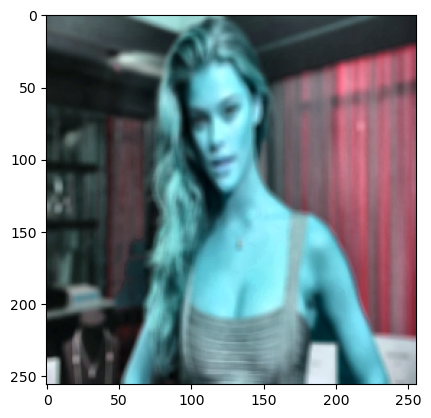

relativa label:  [0. 0. 1. 0.]
label decodificata:  modella
________________________
________________________
valore minimo:  0.0
valore massimo:  1.0


In [ ]:
for camera_batch, classi_batch in generatore_batch_classification(cartella = "data", batch_size = 16, dimensione_output = (256,256), augmentation = True):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("________________________")
    print("esempio di immagine: ")
    plt.imshow(camera_batch[0])
    plt.show()
    print("relativa label: ", classi_batch[0])
    print("label decodificata: ", class_names[np.argmax(classi_batch[0])])
    print("________________________")
    print("________________________")
    print("valore minimo: ", np.min(camera_batch[0]))
    print("valore massimo: ", np.max(camera_batch[0]))
    break
    

## Datasets

In [ ]:
# train: 80%
# validation: 10%
# test: 10%

dataset = tf.data.Dataset.from_generator(
    generatore_batch_classification,
    args=(cartella_data, batch_size, dimensione_output, augmentation),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, dimensione_output[0], dimensione_output[1], 3)),  # Immagine della camera
        tf.TensorSpec(shape=(batch_size, len(class_names))),  #label
    )
)

# test del dataset
for camera_batch, classi_batch in dataset.take(1):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)

dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 4)


In [ ]:
# split del dataset
dimensione_dataset = numero_immagini//batch_size
train_size = int(0.9 * dimensione_dataset)
val_size = int(0.1 * dimensione_dataset)
#test_size = int(0.1 * dimensione_dataset)

immagini_utilizzate = train_size + val_size# + test_size
if immagini_utilizzate < dimensione_dataset:
    train_size += dimensione_dataset - immagini_utilizzate

trainset = dataset.take(train_size)
#testset = dataset.skip(train_size)
valset = dataset.skip(train_size)#+test_size)

print("numero di batch di train: ", train_size)
print("numero di batch di validation: ", val_size)
#print("numero di batch di test: ", test_size)

numero di batch di train:  13
numero di batch di validation:  1
numero di batch di test:  1


In [ ]:
# test del dataset
for camera_batch, classi_batch in valset:
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)

dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 4)
dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 4)


## Callbacks

In [ ]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='./models/model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True
    ),

    callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=20,
        restore_best_weights=True,
    ),

    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20
    )
]

# Modelli

## Sequential

In [ ]:
modello_convoluzionale = Sequential([
        #Resizing(256, 256, interpolation="nearest"),
        # downpart
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        # uppart
        UpSampling2D(),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),

        Dense(len(class_names), activation='softmax'),  # lo strato dense con il n definisce il numero di neuroni, devono essere n_classi perchè abbiamo n_classi classi, e ritorna 1 valore per ogni classe nella terza dimensione delle label
        # siccome devo riestituire una singola label devo modificare l'output del modello da (batch_size, 256, 256,  n_classi) a (batch_size, n_classi)
        # per fare ciò uso un layer globale di pooling che mi restituisce un valore per ogni classe
        #GlobalAveragePooling2D() # questo layer mi restituisce un valore per ogni classe
        GlobalMaxPooling2D()
    ])

In [ ]:
modello_convoluzionale.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.F1Score()])
modello_convoluzionale.build(input_shape=(None,dimensione_output[0],dimensione_output[1],3))
modello_convoluzionale.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 512, 512, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 256, 256, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 128)     0         
 g2D)                                                 

In [ ]:
modello_convoluzionale.fit(x=trainset, epochs=1, validation_data=valset, initial_epoch=0)

3/3 [==============================] - 76s 23s/step - loss: 1.3802 - f1_score: 0.1779 - val_loss: 1.3994 - val_f1_score: 0.1000


dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 4)
________________________
esempio di immagine: 


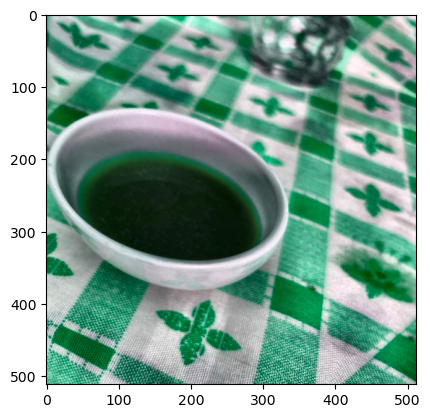

relativa label:  tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
label decodificata:  caffè
________________________
________________________
valore minimo:  0.0
valore massimo:  1.0
1/1 [==============================] - 3s 3s/step
previsone:  [0.28132254 0.3927602  0.2551472  0.22741808]
classificazione:  caffè
dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 4)
________________________
esempio di immagine: 


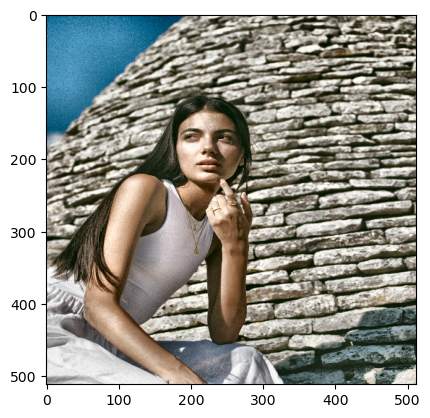

relativa label:  tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
label decodificata:  modella
________________________
________________________
valore minimo:  0.0
valore massimo:  1.0
1/1 [==============================] - 3s 3s/step
previsone:  [0.28155637 0.3905634  0.2532475  0.20536835]
classificazione:  caffè
dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 4)
________________________
esempio di immagine: 


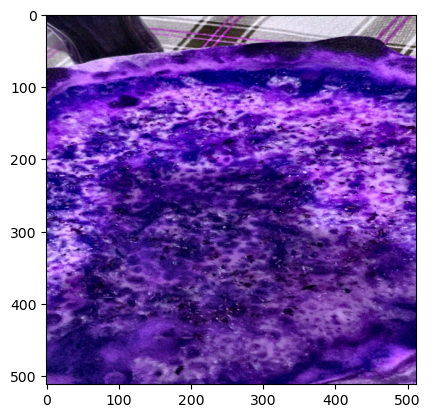

relativa label:  tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
label decodificata:  pizza
________________________
________________________
valore minimo:  0.0
valore massimo:  1.0
1/1 [==============================] - 3s 3s/step
previsone:  [0.2811501  0.3887452  0.2544666  0.21966211]
classificazione:  caffè


In [ ]:
# test del modello
for camera_batch, classi_batch in valset:
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("________________________")
    print("esempio di immagine: ")
    plt.imshow(camera_batch[0])
    plt.show()
    print("relativa label: ", classi_batch[0])
    print("label decodificata: ", class_names[np.argmax(classi_batch[0])])
    print("________________________")
    print("________________________")
    print("valore minimo: ", np.min(camera_batch[0]))
    print("valore massimo: ", np.max(camera_batch[0]))
    
    previsone = modello_convoluzionale.predict(camera_batch)
    print("previsone: ", previsone[0])
    print("classificazione: ", class_names[np.argmax(previsone[0])])

### RES-NET

In [ ]:
n_classi = len(class_names)
class ResBlock(keras.Model):
    def __init__(self,num_hidden):
        super().__init__()
        self.conv1 = keras.layers.Conv2D(num_hidden, kernel_size = 3, padding = "same")
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(num_hidden, kernel_size = 3, padding = "same")
        self.bn2 = keras.layers.BatchNormalization()
        
    def call(self, x):
        residui = x
        x = tf.nn.relu(self.bn1(self.conv1(x))) #il valore di input del "blocco" passa per "conv1", il suo output passa per bn1 (normalizza il batch, ossia li porta tra 0 e 1) e infine passa per la relu
        x = self.bn2(self.conv2(x))
        x += residui # questa è la skip connection (sommiamo l'input con l'output del blocco) # quindi l'insieme di filtri (batch x dimensione x dimensione x dim filtri)
        return tf.nn.relu(x)

    
class ResNet(keras.Model):
    def __init__(self, n_blocchi, n_hidden):
        super().__init__()
        self.start_block = keras.Sequential([
            keras.layers.Conv2D(n_hidden, kernel_size = 3, padding = "same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU()])
        self.back_bone = [ResBlock(n_hidden) for _ in range(n_blocchi)] # l'insieme di tutti i ResBlock
        self.fine = keras.Sequential([
            Dense(len(class_names), activation='softmax'),
            GlobalMaxPooling2D()]) # output della rete
    
    def call(self, x):
        x = self.start_block(x)
        for resblock in self.back_bone:
            x = resblock(x)
        risultato_rete = self.fine(x)
    
        return risultato_rete

In [ ]:
model_resnet = ResNet(n_blocchi = 10, n_hidden = 64)

In [ ]:
model_resnet.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.F1Score()])
model_resnet.build(input_shape=(None,dimensione_output[0],dimensione_output[1],3))
model_resnet.summary()

Model: "res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 512, 512, 64)      2048      
                                                                 
 res_block_10 (ResBlock)     multiple                  74368     
                                                                 
 res_block_11 (ResBlock)     multiple                  74368     
                                                                 
 res_block_12 (ResBlock)     multiple                  74368     
                                                                 
 res_block_13 (ResBlock)     multiple                  74368     
                                                                 
 res_block_14 (ResBlock)     multiple                  74368     
                                                                 
 res_block_15 (ResBlock)     multiple                  74

In [ ]:
model_resnet.fit(x=trainset, epochs=3, validation_data=valset, initial_epoch=0)

Epoch 1/3


      2/Unknown - 324s 103s/step - loss: 1.3872 - f1_score: 0.1000

In [ ]:
# test del modello
for camera_batch, classi_batch in valset:
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("________________________")
    print("esempio di immagine: ")
    plt.imshow(camera_batch[0])
    plt.show()
    print("relativa label: ", classi_batch[0])
    print("label decodificata: ", class_names[np.argmax(classi_batch[0])])
    print("________________________")
    print("________________________")
    print("valore minimo: ", np.min(camera_batch[0]))
    print("valore massimo: ", np.max(camera_batch[0]))
    
    previsone = model_resnet.predict(camera_batch)
    print("previsone: ", previsone[0])
    print("classificazione: ", class_names[np.argmax(previsone[0])])